# ReAct AI Agent from scratch with LangGraph
* Notebook by Adam Lang
* Date: 10/8/2024

# Overview
In this notebook we will build 3 ReAct agents from scratch:
1. Basic Chatbot with LangGraph
2. Simple ReAct Agent with LangGraph using LLM + Tools
3. Multi-user conversational ReAct Agent with LangGraph

# Install Dependencies

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 591.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.0/397.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

## Enter Open AI key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API key: ')

Enter Open AI API key: ··········


## Enter Tavily Search API key

In [3]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Enter WeatherAPI key

In [4]:
WEATHER_API_KEY = getpass('Enter WeatherAPI API key: ')

Enter WeatherAPI API key: ··········


## Setup Environment Variables

In [5]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# 1. Build Basic Chatbot with LangGraph
* First we create a simple chatbot with LangGraph.
* The chatbot will respond directly to user messages.
  * We first create a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine".
  * `nodes` represent the LLM and functions our chatbot can call.
  * `edges` specify how the bot should transition between these functions.

In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


## define Class for State
class State(TypedDict):
  # Messages have the type "list"
  # The 'add_messages' function in the annotation defines how the state key should be updated
  # (in this case, it appends messages to list, rather than overwriting them)
  messages: Annotated[list, add_messages]


## create StateGraph
graph_builder = StateGraph(State)

## Graph knows 2 things:
1. Every node we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be appended to the current list rather than directly overwritten.
  * This is communicated via the prebuilt `add_messages` function in the `Annotated` syntax.

## Next we add a `chatbot` node
* Nodes are units of work and typically python functions.
* This is a simple node which will just send our messages to an LLM.

In [7]:
from langchain_openai import ChatOpenAI

## llm instantiate
chatgpt = ChatOpenAI(model='gpt-4o', temperature=0)

## chatbot function
def chatbot(state: State):
  return {'messages': [chatgpt.invoke(state['messages'])]}


# first argument is unique node name
# second argument is function or object
# this function will be called whenever node is used

##add this to the graph
graph_builder.add_node('chatbot', chatbot)

* The `chatbot` node function takes the current `State` as input and returns an updated `messages` list.
* This is the basic pattern for all LangGraph node functions.
* The `add_messages` function in our `State` will append the LLMs response messages to whatever messages are already in state.
* Next, we add an `entry` point which tells our graph **where to start its work** each time it is run.

In [8]:
## graph_builder
graph_builder.set_entry_point('chatbot')

We also set a `finish` point.
  * This will instruct the graph **anytime this node is run, you can exit.**

In [9]:
graph_builder.set_finish_point('chatbot')

No we can compile the graph by calling `compile()` on the graph builder.
  * This creates a `CompiledGraph` we can use to invoke on our state.

In [10]:
graph = graph_builder.compile()

## View Graph Architecture

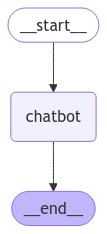

In [11]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
## now we can prompt this simple chatbot
prompt = """What is the fastest animal on land?"""
response = graph.invoke({"messages": ("user", prompt)})

In [13]:
response

{'messages': [HumanMessage(content='What is the fastest animal on land?', id='6903f7af-0c37-4fb0-97b6-1a6cfcc7363e'),
  AIMessage(content='The fastest animal on land is the cheetah. It can reach speeds of up to 60 to 70 miles per hour (97 to 113 kilometers per hour) in short bursts covering distances up to 1,500 feet (460 meters), and it can accelerate from 0 to 60 miles per hour in just a few seconds.', response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 15, 'total_tokens': 85, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_a7d06e42a7', 'finish_reason': 'stop', 'logprobs': None}, id='run-48c55893-c70a-4cf2-bf58-a7122f75425d-0')]}

In [14]:
## another prompt
prompt = """What is langraph?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

Langraph is a platform designed to facilitate the creation and deployment of AI applications, particularly those that leverage large language models (LLMs). It provides tools and infrastructure to help developers build, test, and manage AI-driven applications more efficiently. Langraph typically offers features such as a visual interface for designing workflows, integration with various APIs, and support for deploying applications in different environments. It aims to simplify the process of working with complex AI models and make it more accessible for developers to implement AI solutions in their projects.

## Summary
* We just built a simple chatbot usingLangGraph and it can be used for simple question and answer without memory.
* It also does not use any tools right now to augment its lack of training data past October 2023.
* Next we will enhance it with tools.

# 2. Simple ReAct Agent in LangGraph from scratch

We will do the following:
1. Build the agent completely from scratch.
2. Leverage LangGraph built-in node functions to build the agent faster.

## Create Tools
* Here we will create 2 custom tools which are wrappers on top of the Tavily API and WeatherAPI.
  * Simple Web Search tool
  * Weather tool

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults #Tavily
from langchain_core.tools import tool #tool
import json #output parser
import requests

## init search
tv_search = TavilySearchResults(max_results=3,
                                search_depth='advanced',
                                max_tokens=10000)

# search tool
@tool
def search_web(query: str) -> list:
  """Tool to search web for query"""
  results = tv_search.invoke(query)
  return results

# weather tool
@tool
def get_weather(query: str) -> list:
  """Tool to search weatherAPI for current weather"""
  base_url = "http://api.weatherapi.com/v1/current.json"
  complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"

  response = requests.get(complete_url)
  data = response.json()
  if data.get("location"):
    return data
  else:
    return "Weather Data Not Found"


## Build Agentic Graph from Scratch
* Here we will use LangGraph to build full graph which will have Agentic workflow.
* Each functionality will be implemented from scratch.

In [16]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

## State graph
class State(TypedDict):
  messages: Annotated[list, add_messages] #one key is list of messages

# instantiate State Graph
graph_builder = StateGraph(State)

## define LLM
llm = ChatOpenAI(model='gpt-4o', temperature=0)
# now tell LLM which tools it can call
tools = [search_web, get_weather]
llm_with_tools = llm.bind_tools(tools)

#chatbot --> pass to LLM with tools
def chatbot(state: State):
  return {'messages': [llm_with_tools.invoke(state['messages'])]}


## add node --> chatbot
graph_builder.add_node('chatbot', chatbot)

We now create a function to run the tools if they are called. We'll do this by adding the tools to a new node.

We implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`.

It relies on the LLM's `tool_calling` support which is available in Anthropic, OpenAI, Google Gemini, and other LLM providers.

We will later replace this with LangGraph's prebuilt `ToolNode` to speed up this process but building from scratch gives good idea of what happens under hood.

In [17]:
import json
from langchain_core.messages import ToolMessage

# basic tool node class
class BasicToolNode:
  """A node that runs tools requested in last AIMessage."""

  def __init__(self, tools: list) -> None:
    self.tools_by_name = {tool.name: tool for tool in tools} # => {'search_web': search_web, 'get_weather': get_weather}

  # call will actually invoke the tools
  def __call__(self, inputs: dict):
    # assign messages --> messages var with "walrus" operator
    if messages := inputs.get('messages', []):
      message = messages[-1] # get most recent message
    else:
      raise ValueError('No message found in input')
    # create empty list
    outputs = []
    # if tools calls are mentioned by LLM in most recent message
    # call tool and get result
    for tool_call in message.tool_calls:
      tool_result = self.tools_by_name[tool_call['name']].invoke(
          tool_call['args']
      )
      outputs.append(
          ToolMessage(
              content=json.dumps(tool_result),
              name=tool_call['name'],
              tool_call_id=tool_call['id']
          )
      )

    return {'messages': outputs}

# add tool node to graph
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node('tools', tool_node)

Now with tool node added we can define `conditional_edges`.

Recall that **edges** route controls flow from one node to next.

**Conditional edges** usually contain "if" statements to route to different nodes depending on current graph state.

These functions receive current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, we are going to define a router function called `route_tools` that checks for `tool_calls` in chatbots output.

We provide function to the graph by calling `add_conditional_edges` which tells graph whenever `chatbot` node completes the check function to see where to go next.

Condition will route to `tools` if tool calls are present and "`__end__`" if not.

Later on we will replace this with the prebuilt `tools_condition` to be more concise, here we implement it from scratch to see what happens under hood.

In [18]:
from typing import Literal

# router for tools
def route_tools(state: State,) -> Literal['tools', '__end__']:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """

    # check if state of graph is a list of messages get the last one
    if isinstance(state, list):
      ai_message = state[-1]
    # if state is a dict, try to get last message from messages key
    elif messages := state.get('messages', []):
      ai_message = messages[-1]
    else:
      raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # if last message is refering to a tool call, route to the tools node
    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
      return "tools"
    # else route to end (stop the AGENT)
    return "__end__"


# The 'tools_conditon' function returns "tools"
# if the chatbot asks to use a tool,
# and "__end__" if it is fine directly responding and stopping the agent.
# This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
      'chatbot',
      route_tools
  )


# any time a tool is called, we return to the chatbot to decide next step
graph_builder.add_edge('tools', 'chatbot')
# set entry point --> prompt that goes into chatbot
graph_builder.set_entry_point('chatbot')
# compile graph
graph = graph_builder.compile()

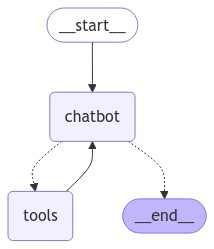

In [19]:
## display the graph
from IPython.display import Image, display, Markdown

## display
display(Image(graph.get_graph().draw_mermaid_png()))

Lets test out the agent!

In [20]:
prompt = """What is the slowest animal on land?"""
response = graph.invoke({'messages': ('user', prompt)})
display(Markdown(response['messages'][-1].content))

The slowest animal on land is the three-toed sloth. Sloths are known for their extremely slow movement, which is an adaptation to conserve energy. They move at an average speed of about 0.24 kilometers per hour (0.15 miles per hour) when on the ground.

In [21]:
response

{'messages': [HumanMessage(content='What is the slowest animal on land?', id='a50d084c-f134-435f-8c5f-7afcbea30e96'),
  AIMessage(content='The slowest animal on land is the three-toed sloth. Sloths are known for their extremely slow movement, which is an adaptation to conserve energy. They move at an average speed of about 0.24 kilometers per hour (0.15 miles per hour) when on the ground.', response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 76, 'total_tokens': 137, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_a7d06e42a7', 'finish_reason': 'stop', 'logprobs': None}, id='run-500e40cc-6655-4b4e-90b9-0eb3fff129b2-0')]}

In [22]:
## another prompt
prompt = """What is langraph?"""
response = graph.invoke({'messages': ('user', prompt)})
display(Markdown(response['messages'][-1].content))

LangGraph is a framework designed for building stateful, multi-actor applications using large language models (LLMs). It is part of the LangChain ecosystem and is used to handle complex scenarios and facilitate collaboration between multiple agents, including humans. LangGraph supports the development of applications with features like cycles, controllability, and persistence, and can be used with tools like LangChain, LangSmith, and Anthropic. It is available for use with programming languages such as Python and JavaScript, and can be deployed using LangGraph Cloud.

In [23]:
response

{'messages': [HumanMessage(content='What is langraph?', id='b43f0f4f-f38e-4c97-a672-04562e1a5b07'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KbLKEPwGFAzWMHXCB62qYD3S', 'function': {'arguments': '{"query":"langraph"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 72, 'total_tokens': 87, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_a7d06e42a7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0bb1c048-8a7b-46c8-b459-f5197ebcee27-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'langraph'}, 'id': 'call_KbLKEPwGFAzWMHXCB62qYD3S', 'type': 'tool_call'}]),
  ToolMessage(content='[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building stateful, multi-actor agents with LLMs that can

## Build the same Agentic Graph with LangGraph built-ins -- Recommended Workflow

Here we will use LangGraph to build the full graph which will have an Agentic workflow.

Each functionality will be implemented as we would in the real-world.

Here we are replacing our `BasicToolNode` for the prebuilt `ToolNode` and our `route_tools` condition with the prebuilt `tools_condition`

In [24]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults #Tavily
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

## langgraph imports
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# define function to store all agent messages
class State(TypedDict):
  messages: Annotated[list, add_messages]

# start graph building
graph_builder = StateGraph(State)

# add tools and bind to LLM
tools = [search_web, get_weather]
llm = ChatOpenAI(model='gpt-4o', temperature=0)
llm_with_tools = llm.bind_tools(tools)

# add LLM to graph
def chatbot(state: State):
  return {'messages': [llm_with_tools.invoke(state['messages'])]}


#add node to graph
graph_builder.add_node('chatbot', chatbot)


# Add tools to a node
tool_node = ToolNode(tools=tools)
graph_builder.add_node('tools', tool_node)

# add conditional edges --> dont need to create route function as we did before
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition,
    {'tools': 'tools', '__end__': '__end__'}
)


# Any time a tool is called, we return to chatbot to decide next step
graph_builder.add_edge('tools', 'chatbot')
# define graph entry point --> prompt
graph_builder.set_entry_point('chatbot')
# compile graph
graph = graph_builder.compile()

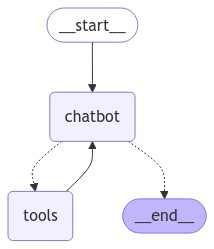

In [25]:
## display output
from IPython.display import Image, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
## prompt
prompt = """What is the weather in Denver, CO? Show detailed stats."""
response = graph.invoke({'messages': ('user', prompt)})
display(Markdown(response['messages'][-1].content))

The current weather in Denver, CO is as follows:

- **Condition**: Sunny ![Sunny](https://cdn.weatherapi.com/weather/64x64/day/113.png)
- **Temperature**: 22.4°C (72.3°F)
- **Feels Like**: 23.4°C (74.1°F)
- **Wind**: 8.9 mph (14.4 kph) from the Northwest (NW)
- **Wind Gusts**: Up to 10.3 mph (16.6 kph)
- **Humidity**: 20%
- **Pressure**: 1016.0 mb (30.0 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Cloud Cover**: 0%
- **Visibility**: 11.0 km (6.0 miles)
- **UV Index**: 3.9
- **Dew Point**: 3.4°C (38.0°F)

The weather is clear and sunny, making it a pleasant day in Denver.

In [27]:
## another prompt
prompt = """How many superbowls have the Pats won? Show me stats."""
response = graph.invoke({'messages': ('user', prompt)})
display(Markdown(response['messages'][-1].content))

The New England Patriots have won a total of 6 Super Bowls. Here are some details about their victories:

1. **Super Bowl XXXVI (2002)**: Patriots defeated the St. Louis Rams 20-17.
2. **Super Bowl XXXVIII (2004)**: Patriots defeated the Carolina Panthers 32-29.
3. **Super Bowl XXXIX (2005)**: Patriots defeated the Philadelphia Eagles 24-21.
4. **Super Bowl XLIX (2015)**: Patriots defeated the Seattle Seahawks 28-24.
5. **Super Bowl LI (2017)**: Patriots defeated the Atlanta Falcons 34-28 in overtime.
6. **Super Bowl LIII (2019)**: Patriots defeated the Los Angeles Rams 13-3.

These victories tie them with the Pittsburgh Steelers for the most Super Bowl wins in NFL history.

Summary:
* So far we have built a chatbot but it does not store conversational memory.

# 3. Mult-user conversational ReAct Agent with LangGraph
* Now we will build a mult-user conversational agent with LangGraph.
* We will use the same tools from above Tavily search API and weather api.
* The chatbot we just build in part 2 can use tools to answer questions but it DOES NOT remember the context of the previous query because we are not storing memory.
* LangGraph soles this by using **persistent checkpointing**.
  * If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step.
  * When you invoke the graph again using the same `thread_id` the graph loads its saved state allowing the chatbot to pick up where you left off.

* **Checkpointing** is **more** powerful than simple chat memory - it allows you to save and resume complex state at any time for error recovery, human-in-the_loop workflows, time-travel interactions and more.
  * While legacy syntax uses `session_id`, LangGraph will build a session by `thread_id`
* We will use the `SqliteSaver` which stores separate converational histories per user or session.
* This will help us build a conversational Agentic Chatbot which will be accessed by many users at the SAME time.

In [28]:
## code below removes memory database file -- usually not needed
## you can run this only if you want to remove all conversation histories
## ok if you get --> rm: cannot remove 'memory.db': No such file or directory because initially no memory exits
!rm memory.db*

rm: cannot remove 'memory.db*': No such file or directory


In [29]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

## langgraph imports
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver #sql database --> store conversations in memory

# used to retrieve conversation history from database
# based on a specific user or session ID
memory = SqliteSaver.from_conn_string('memory.db') ##database file for conversations




# define function which will be used to store all agent messages
class State(TypedDict):
  messages: Annotated[list, add_messages]

# start graph building
graph_builder = StateGraph(State)

# add tools and bind to LLM
tools = [search_web, get_weather]
llm = ChatOpenAI(model='gpt-4o', temperature=0)
llm_with_tools = llm.bind_tools(tools)



## add llm to graph
def chatbot(state: State):
  return {'messages': [llm_with_tools.invoke(state['messages'])]}


## add node
graph_builder.add_node('chatbot', chatbot)

## add tools to node
tool_node = ToolNode(tools=tools)
graph_builder.add_node('tools', tool_node)


# add conditional edges
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition,
    # either goes to tool node if tool calls or else end node
    {'tools': 'tools', '__end__': '__end__'}
)

# any time a tool is called, we return to chatbot to decide next step
graph_builder.add_edge('tools', 'chatbot')
# define entry point to graph
graph_builder.set_entry_point('chatbot')




## most important step!!!
# compile graph -- add memory here
graph = graph_builder.compile(checkpointer=memory)

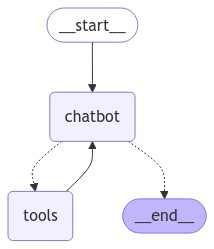

In [32]:
## display
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
## now we can create an agent
def chat_with_agent(prompt: str, session_id: str):
  response = graph.invoke({'messages': [('user', prompt)]},
                          {'configurable': { 'thread_id': session_id}})

  ## display
  display(Markdown(response['messages'][-1].content))

Simulating User 1 using the agent

In [34]:
user_id = 'taylor1989'
prompt = "Tell me about the ERAS tour"
chat_with_agent(prompt, user_id)

The "Eras Tour" is a concert tour by Taylor Swift, which has gained significant attention and success. Here are some key details about the tour:

1. **Tour Success**: The Eras Tour is on track to become one of the biggest in concert history, with potential gross earnings projected to exceed $1 billion. As of October 2023, the tour had grossed $2 billion.

2. **Ticket Sales**: The tour experienced unprecedented demand for tickets, leading to a crash on Ticketmaster's website during the U.S. presale. Ticket prices ranged from $49 to $449, with VIP packages from $199 to $899.

3. **Tour Dates and Locations**: The tour includes multiple shows across the U.S. and internationally. Due to high demand, additional shows were added in the U.S.

4. **Set List and Performances**: The set list includes a variety of songs from Taylor Swift's discography, with surprise songs performed at each show. The performances are known for their meticulous camerawork and energetic vocals.

5. **Economic Impact**: The tour has significantly boosted Taylor Swift's net worth, making her the first billionaire in history with music as the main source of income.

6. **Cultural Impact**: The tour has fueled an increase in public consumption of Swift's discography and has set records for ticket sales, comparable to major blockbuster films.

Overall, the Eras Tour is a major cultural and economic event, showcasing Taylor Swift's extensive music career and her ability to draw massive audiences worldwide.

In [35]:
prompt = "When was the last show?"
chat_with_agent(prompt, user_id)

The final date of Taylor Swift's Eras Tour is scheduled for Sunday, December 8, 2024, at BC Place in Vancouver.

Simulate user 2 using the agent

In [42]:
user_id = "steelers3"
prompt = "What is the weather in Zurich today? Show me detailed stats."
chat_with_agent(prompt, user_id)

Here's a detailed weather report for Zurich today:

- **Condition**: Clear
- **Temperature**: 11°C (51.8°F)
- **Feels Like**: 11.2°C (52.2°F)
- **Wind**: 
  - Speed: 4.0 kph (2.5 mph)
  - Direction: South (170°)
- **Pressure**: 1027.0 mb (30.33 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Humidity**: 100%
- **Cloud Cover**: 0%
- **Visibility**: 10 km (6 miles)
- **UV Index**: 0.0
- **Gusts**: Up to 8.3 kph (5.2 mph)
- **Dew Point**: 10°C (50°F)

The weather is calm and clear, with no clouds or precipitation.

In [43]:
user_id = 'steelers3'
prompt = "what about Anchorage?"
chat_with_agent(prompt, user_id)

Here's a detailed weather report for Anchorage today:

- **Condition**: Overcast
- **Temperature**: 3.3°C (37.9°F)
- **Feels Like**: 1.9°C (35.3°F)
- **Wind**: 
  - Speed: 5.8 kph (3.6 mph)
  - Direction: Southeast (143°)
- **Pressure**: 1019.0 mb (30.08 in)
- **Precipitation**: 0.01 mm (0.0 in)
- **Humidity**: 73%
- **Cloud Cover**: 100%
- **Visibility**: 16 km (9 miles)
- **UV Index**: 0.1
- **Gusts**: Up to 9.8 kph (6.1 mph)
- **Dew Point**: -2.7°C (27.1°F)

The weather in Anchorage is overcast with full cloud cover and a slight chill in the air.

In [44]:
user_id = 'steelers3'
prompt = "which city is colder?"
chat_with_agent(prompt, user_id)

Anchorage is colder than both Zurich and Stockholm. The current temperature in Anchorage is 3.3°C (37.9°F), compared to Zurich's 11°C (51.8°F) and Stockholm's 13.1°C (55.6°F).

In [45]:
user_id = 'steelers3'
prompt = "which city most recently had rain?"
chat_with_agent(prompt, user_id)

Anchorage most recently had rain, with a recorded precipitation of 0.01 mm. Both Zurich and Stockholm currently have no precipitation.